### Прогнозирование волатильности с помощью ARCH/GARCH

#### Что такое волатильность?

- Описывает дисперсию доходности финансовых активов с течением времени.
- Часто вычисляется как стандартное отклонение или дисперсия доходности цен.
- Чем выше волатильность, тем рискованнее финансовый актив.

#### Задача моделирования волатильности

**Гетероскедастичность:**

- На древнегреческом: «разный» (hetero) + «рассеивание» (skedasis)
- Ряд временных данных демонстрирует изменяющуюся волатильность, систематически меняющуюся со временем.



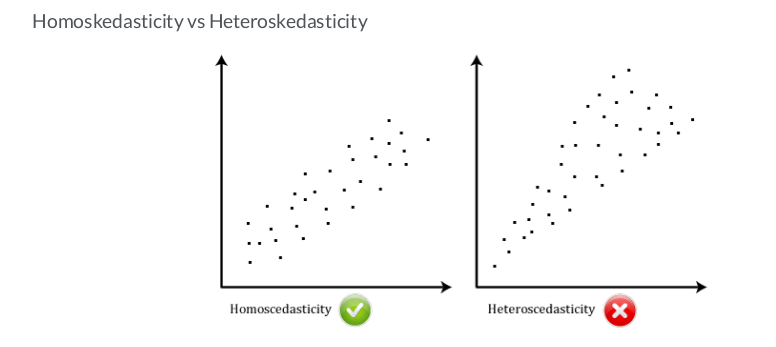

#### Imports & Settings

In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
import yfinance as yf

In [2]:
# %matplotlib inline
# pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')
# sns.set(style="darkgrid", color_codes=True)
# rcParams['figure.figsize'] = 8,4

#### Функция экспоненты Херста

Экспонента Херста — это статистическая мера, используемая для классификации временных рядов и определения степени сложности прогнозирования, а также выбора подходящей модели для анализа ряда. Она служит показателем долгосрочной памяти временного ряда.

Экспонента Херста связана с автокорреляциями временного ряда и тем, с какой скоростью они убывают по мере увеличения лага между парами значений.

- Значение около 0.5 указывает на случайный (хаотичный) ряд.
- Значение около 0 — на средне-возвращающийся (mean-reverting) ряд.
- Значение около 1 — на трендовый ряд.

In [2]:
def hurst(ts):
    """Возвращает экспоненту Херста для вектора временного ряда ts"""
    
    # Создаём диапазон значений лага
    lags = range(2, 100)
    
    # Вычисляем массив дисперсий разностей с лагом
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Используем линейную аппроксимацию для оценки экспоненты Херста
    poly = polyfit(log(lags), log(tau), 1)
    
    # Возвращаем экспоненту Херста из результата polyfit
    return poly[0]*2.0

#### График коррелограммы

In [3]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

#### Скачать данные по индексу S&P 500

Мы будем использовать дневную доходность индекса S&P 500 за период с 2005 по 2020 год, чтобы продемонстрировать применение модели GARCH.

In [4]:
start = pd.Timestamp('2005-01-01')
end = pd.Timestamp('2020-04-09')

start = '2005-01-01'
end = '2020-04-09'

sp_data = pd.read_csv("portfolio_2015_2025.csv")
sp_data = sp_data.rename(columns={'Unnamed: 0': 'Date'})
sp_data = sp_data.rename(columns={'GAZP': 'Close'})

In [5]:
sp_data = sp_data[['Date', 'Close']]
sp_data.head()

,Date,Close
0,2015-01-06,138.92
1,2015-01-08,146.46
2,2015-01-09,141.70
3,2015-01-12,140.22
4,2015-01-13,142.64


#### Наблюдение за кластеризацией волатильности

Кластеризация волатильности — это наблюдение, что «большие изменения, как правило, сопровождаются большими изменениями любого знака, и маленькие изменения, как правило, сопровождаются маленькими изменениями.

- Кластеризация волатильности часто наблюдается в данных финансовых рынков, и она представляет собой сложную задачу для моделирования временных рядов.

С использованием набора данных по дневным ценам S&P 500 мы рассчитываем дневные доходности как процентные изменения цен, строим график этих изменений и наблюдаем за их поведением с течением времени.

In [6]:
# Рассчитываем дневные доходности как процентные изменения цен
sp_data['Return'] = 100 * (sp_data['Close'].pct_change())
sp_data['Log_Return'] = np.log(sp_data['Close']).diff().mul(100) # перескалибровка для облегчения оптимизации
sp_data = sp_data.dropna()
sp_data

,Date,Close,Return,Log_Return
1,2015-01-08,146.46,5.427584,5.285413
2,2015-01-09,141.70,-3.250034,-3.304021
3,2015-01-12,140.22,-1.044460,-1.049953
4,2015-01-13,142.64,1.725859,1.711136
5,2015-01-14,146.30,2.565900,2.533533
...,...,...,...,...
2573,2025-04-07,125.57,-0.891871,-0.895872
2574,2025-04-08,121.91,-2.914709,-2.958030
2575,2025-04-09,127.76,4.798622,4.687044
2576,2025-04-10,127.77,0.007827,0.007827


In [7]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

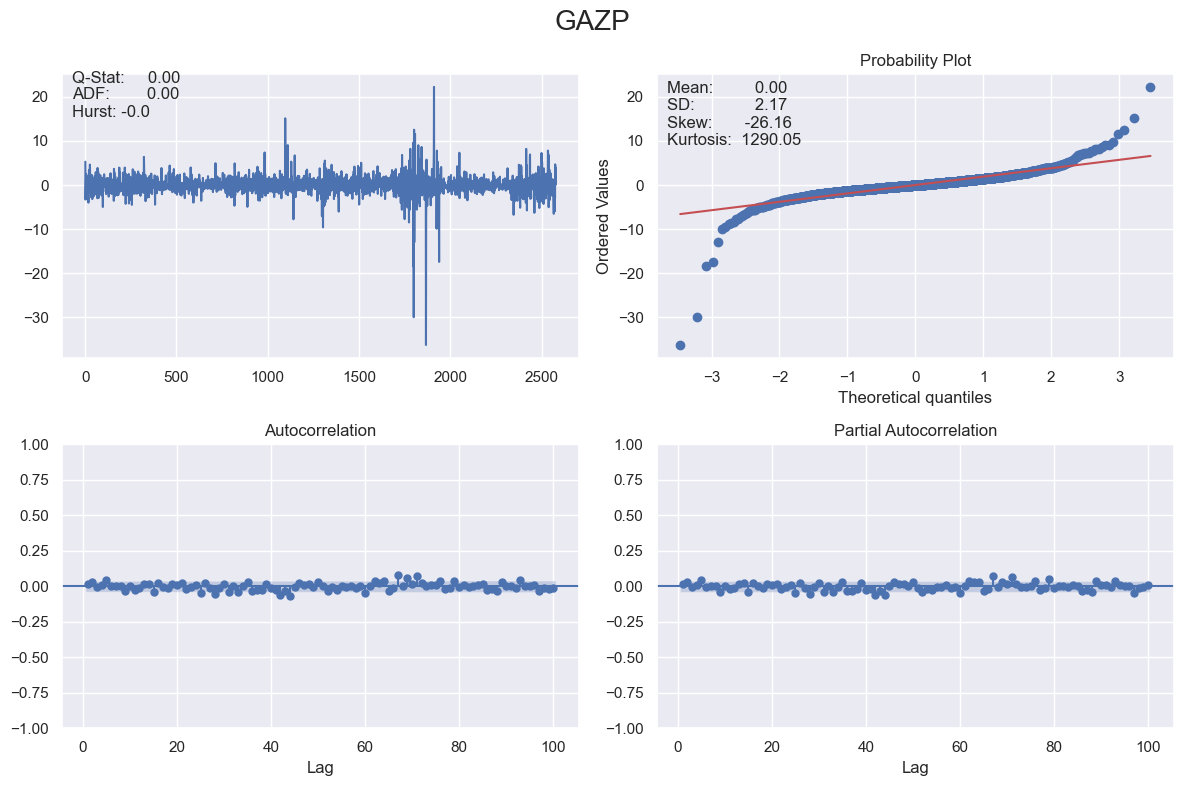

In [8]:
# Строим ACF, PACF и Q-Q график, а также получаем p-значение ADF для ряда
plot_correlogram(sp_data['Log_Return'], lags=100, title='GAZP')

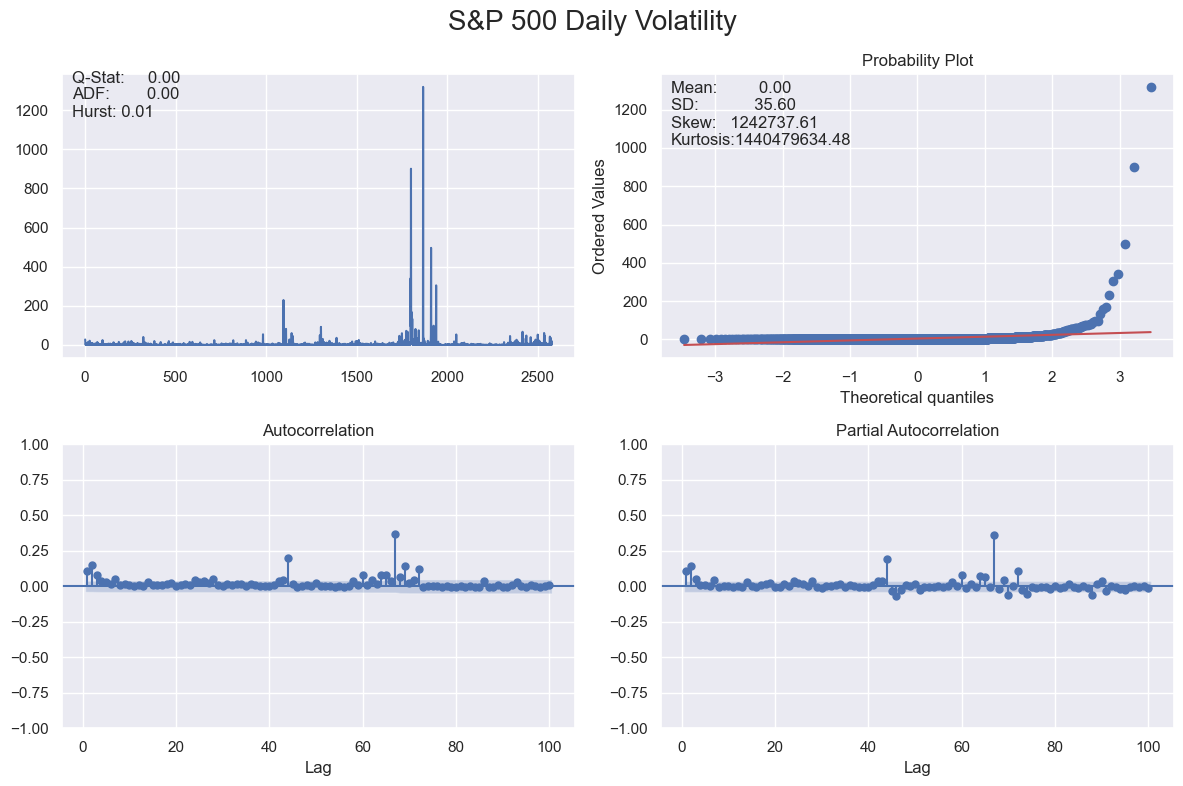

In [9]:
plot_correlogram(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), lags=100, title='S&P 500 Daily Volatility')

#### Вычисление волатильности

Мы вычисляем и конвертируем волатильность доходности цен в Python.

Сначала мы вычисляем дневную волатильность как стандартное отклонение доходности цен. Затем конвертируем дневную волатильность в месячную и годовую волатильность.

In [10]:
# Рассчитываем стандартное отклонение доходностей за день
std_daily = sp_data['Return'].std()
print(f'Дневная волатильность: {round(std_daily, 2)}%')

# Преобразуем дневную волатильность в месячную волатильность
std_monthly = np.sqrt(21) * std_daily
print(f'\nМесячная волатильность: {round(std_monthly, 2)}%')

# Преобразуем дневную волатильность в годовую волатильность
std_annual = np.sqrt(252) * std_daily
print(f'\nГодовая волатильность: {round(std_annual, 2)}%')

Дневная волатильность: 2.13%

Месячная волатильность: 9.76%

Годовая волатильность: 33.82%


#### ARCH и GARCH

Сначала появился ARCH

- Автогрегрессивная условная гетероскедастичность
- Разработано Робертом Ф. Энглом (лауреат Нобелевской премии 2003 года)

Затем появился GARCH

- "Обобщённая" ARCH
- Разработано Тимом Боллерслевом (учеником Роберта Ф. Энгла)

#### Математические обозначения модели

Ожидаемая доходность:

$$ \mu = \mathbb{E}[r_t | I(t-1)] $$

Ожидаемая волатильность:

$$ \sigma^2 = \mathbb{E}[(r_t - \mu_t)^2 | I(t-1)] $$

Остаток (ошибка прогноза):

$$ r_t = \mu + \epsilon_t $$

Волатильность связана с остатками:

$$ \epsilon_t = \sigma_t \cdot \zeta \quad (\text{Белый шум}) $$

Белый шум ($\zeta$): Несвязанные случайные величины с нулевым средним и конечной дисперсией.


#### Интуиция модели:
- Автогрегрессия: предсказание будущего поведения на основе прошлого поведения.
- Волатильность как взвешенное среднее прошлой информации.

#### Ограничения параметров модели GARCH(1,1):

Все параметры неотрицательны, так как дисперсия не может быть отрицательной.

$$ \omega, \alpha, \beta \geq 0 $$

Оценки модели "возвращаются к среднему" для долгосрочной дисперсии.

$$ \alpha + \beta < 1 $$

Долгосрочная дисперсия:

$$ \frac{\omega}{1 - \alpha - \beta} $$


#### Динамика параметров GARCH(1,1):

- Чем больше $\alpha$, тем больше немедленное воздействие шока.
- Чем больше $\beta$, тем дольше длится эффект воздействия.

Уравнение модели GARCH(1,1):

$$ \sigma^2_t = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1} $$

Интуитивно, прогноз волатильности по модели GARCH можно интерпретировать как взвешенное среднее трёх различных прогнозов дисперсии.

- Первый — это постоянная дисперсия, которая соответствует долгосрочному среднему.
- Второй — это новая информация, которая не была доступна, когда был сделан предыдущий прогноз.
- Третий — это прогноз, который был сделан в предыдущем периоде.

Весовые коэффициенты этих трёх прогнозов определяют, как быстро изменяется дисперсия с новой информацией и как быстро она возвращается к своему долгосрочному среднему.

### Симуляция рядов ARCH и GARCH:

Мы будем симулировать временной ряд ARCH(1) и GARCH(1,1) с использованием функции simulate_GARCH(n, omega, alpha, beta = 0).

Напоминаем, что отличие между моделью ARCH(1) и GARCH(1,1) заключается в том, что помимо автогрегрессии компонента $\alpha$, умножающего на квадраты остатков с лагом 1, модель GARCH включает компонент скользящего среднего, где $\beta$ умножает на дисперсию с лагом 1.

Функция будет симулировать ряд ARCH/GARCH на основе заданных параметров n (количество симуляций), omega, alpha и beta (по умолчанию равного 0). Она вернёт симулированные остатки и дисперсии.


In [11]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Инициализация параметров
    white_noise = np.random.normal(size = n)  # Белый шум
    resid = np.zeros_like(white_noise)  # Остатки
    variance = np.zeros_like(white_noise)  # Дисперсия
    
    for t in range(1, n):
        # Симуляция дисперсии (сигма в квадрате)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Симуляция остатков
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

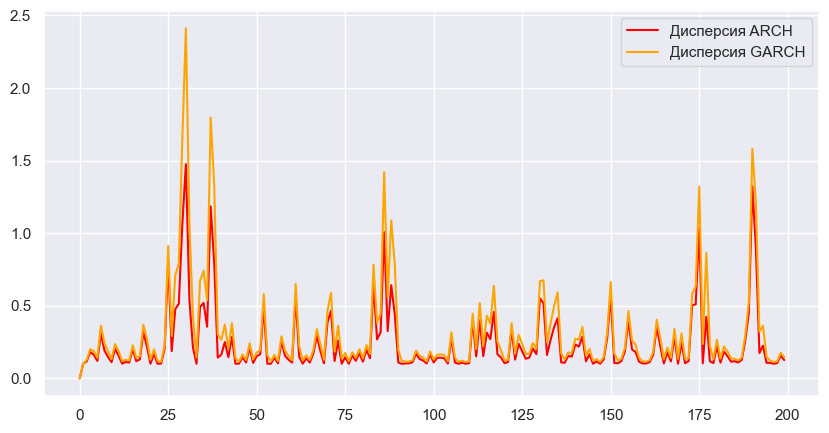

In [12]:
# Симуляция ряда ARCH(1)
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Симуляция ряда GARCH(1,1)
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Построение графика дисперсии для ARCH
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'Дисперсия ARCH')

# Построение графика дисперсии для GARCH
plt.plot(garch_variance, color = 'orange', label = 'Дисперсия GARCH')
plt.legend()
plt.show()


### Наблюдаем влияние параметров модели:

Мы снова вызовем функцию simulate_GARCH() и изучим влияние параметров модели GARCH на симулированные результаты.

Конкретно, мы смоделируем два ряда GARCH(1,1), у которых одинаковые omega и alpha, но разные значения beta.

Напоминаем, что в модели GARCH(1,1), поскольку $\beta$ — это коэффициент для дисперсии с лагом 1, если $\alpha$ фиксировано, то чем больше $\beta$, тем дольше длится влияние. Другими словами, периоды высокой или низкой волатильности имеют тенденцию к длительности. Обратите внимание на построенные графики и посмотрите, можем ли мы подтвердить влияние $\beta$.

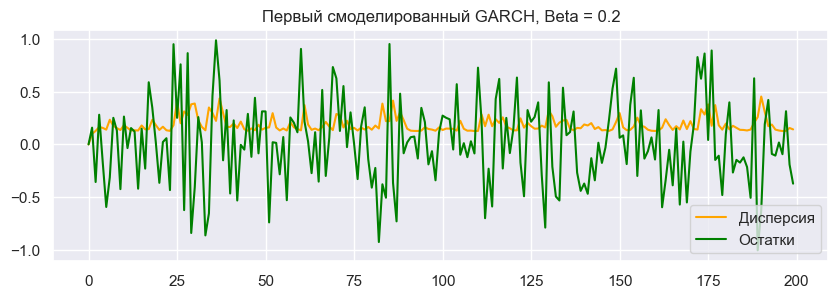

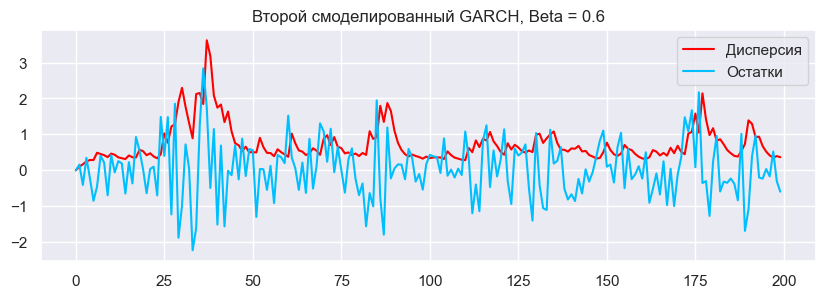

In [13]:
# Первый смоделированный GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Дисперсия')
plt.plot(sim_resid, color = 'green', label = 'Остатки')
plt.title('Первый смоделированный GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Второй смоделированный GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Дисперсия')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Остатки')
plt.title('Второй смоделированный GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

#### Реализация базовой модели GARCH:

Мы познакомимся с пакетом Python `arch` и используем его функции, такие как `arch_model()`, для реализации модели GARCH(1,1).

Сначала определим базовую модель GARCH(1,1), затем подгоним модель, просмотрим сводку по подгонке модели и построим результаты.


In [14]:
# Указать предположения модели GARCH
basic_gm = arch_model(sp_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Подогнать модель
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     28,   Neg. LLF: 5187.256809618504
Iteration:      8,   Func. Count:     52,   Neg. LLF: 5139.469908776641
Iteration:     12,   Func. Count:     74,   Neg. LLF: 5138.460172744431
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5138.460172744319
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [15]:
# Отобразить сводку подгонки модели
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5138.46
Distribution:                  Normal   AIC:                           10284.9
Method:            Maximum Likelihood   BIC:                           10308.3
                                        No. Observations:                 2577
Date:                Mon, Apr 21 2025   Df Residuals:                     2576
Time:                        20:54:14   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0406  2.966e-02      1.367      0.172 

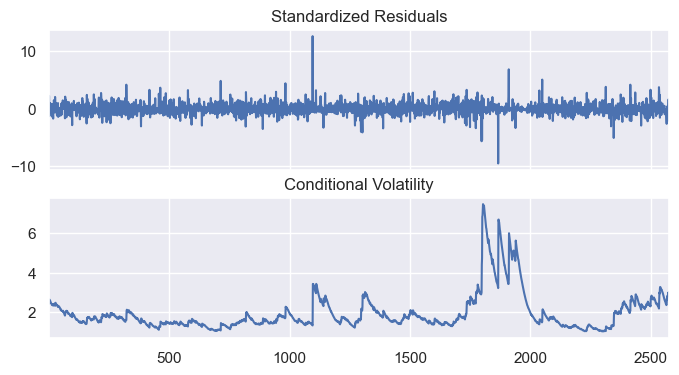

In [16]:
# Построить график подогнанных результатов
gm_result.plot()
plt.show()

#### Прогнозирование с моделями GARCH:

Мы будем практиковаться в создании базового прогноза волатильности.

Мы вызовем метод `.forecast()` для создания прогноза. По умолчанию он предоставляет оценку на один шаг вперёд. Вы можете использовать параметр `horizon = n`, чтобы указать более длительные прогнозируемые периоды.


In [17]:
# Сделать прогноз на 5 периодов вперёд
gm_forecast = gm_result.forecast(horizon = 5)

# Вывести прогнозируемую дисперсию
print(gm_forecast.variance[-1:])

           h.1       h.2       h.3       h.4    h.5
2577  8.924427  8.918041  8.911675  8.905327  8.899


h.1 в строке "2020-04-09": это прогноз на один шаг вперёд, сделанный с использованием данных, включая эту дату.

### Предположения о распределении:

##### Почему мы делаем предположения?

- Волатильность непосредственно не наблюдаема.
- Модели GARCH используют остатки в качестве шоков волатильности.  
$$r_t = \mu + t + \epsilon_t$$

- Волатильность связана с остатками:
$$\epsilon_t = \sigma_t * \zeta(WhiteNoise)$$ 


##### Стандартизированные остатки

- Остаток = предсказанная доходность - средняя доходность  
$$\text{residuals} = \epsilon_t = r_t - \mu_t$$

- Стандартизированный остаток = остаток / волатильность доходности  
$$\text{stdResid} = \frac{\epsilon_t}{\sigma_t}$$

Модели GARCH делают предположения о распределении остатков и средней доходности. Данные финансовых временных рядов часто не следуют нормальному распределению. В финансовых временных рядах гораздо более вероятно наблюдать экстремальные положительные и отрицательные значения, которые значительно отклоняются от среднего. Чтобы улучшить предположения о распределении модели GARCH и сделать их более репрезентативными для реальных финансовых данных, мы можем указать, что предположение о распределении модели будет распределением Стьюдента. Распределение Стьюдента симметрично и колоколообразное, как нормальное распределение, но имеет более тяжелые хвосты, что делает его более склонным к образованию значений, удалённых от среднего. Параметр $\nu$ указывает его форму: чем больше $\nu$, тем более острая становится кривая.

Модели GARCH позволяют указать предположения о распределении стандартизированных остатков. По умолчанию предполагается нормальное распределение, которое имеет симметричную, колоколообразную кривую плотности вероятности. Другие варианты включают распределение Стьюдента и асимметричное распределение Стьюдента.


#### Построение распределения стандартизированных остатков:

Мы будем практиковаться в вычислении стандартизированных остатков из подогнанной модели GARCH, а затем построим их гистограмму вместе с нормально распределённой кривой (normal_resid).

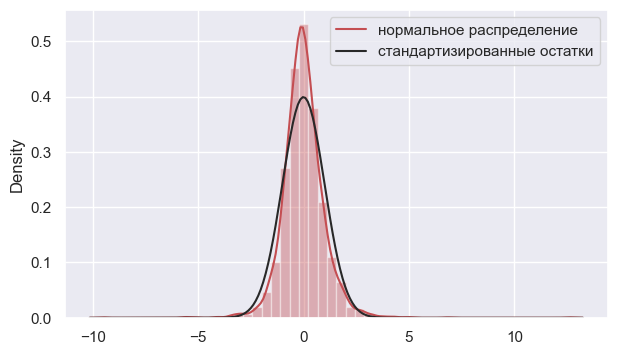

In [18]:
# Получить оценённые моделью остатки и условную волатильность
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Вычислить стандартизированные остатки
gm_std_resid = gm_resid / gm_std

# Построить гистограмму стандартизированных остатков
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('нормальное распределение', 'стандартизированные остатки'))
plt.show()


### Подгонка GARCH-модели с асимметричным t-распределением:

Мы улучшим GARCH-модель, используя предположение об асимметричном t-распределении Стьюдента.

In [19]:
# Задать параметры модели GARCH
skewt_gm = arch_model(sp_data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Оценить модель
skewt_result = skewt_gm.fit(disp = 'off')

# Получить оценённую моделью условную волатильность
skewt_vol = skewt_result.conditional_volatility


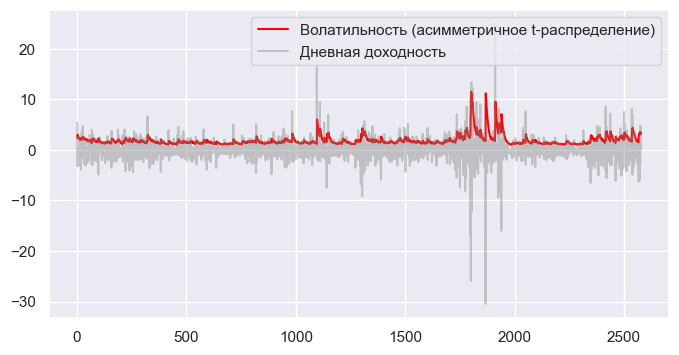

In [20]:
# Построить график результатов подгонки модели
plt.plot(skewt_vol, color = 'red', label = 'Волатильность (асимметричное t-распределение)')
plt.plot(sp_data['Return'], color = 'grey', 
         label = 'Дневная доходность', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

### Спецификации модели среднего значения

- **Постоянное среднее значение (constant mean)**: как правило, хорошо работает для большинства данных о доходности финансовых инструментов.

- **Авторегрессионное среднее значение (autoregressive mean)**: моделирует среднее как авторегрессионный (AR) процесс.

- **Нулевое среднее значение (zero mean)**: используется, когда среднее уже было смоделировано отдельно, и на основе остатков этой модели оценивается волатильность с помощью GARCH-модели (предпочтительный метод).

Здесь мы моделируем логарифмическую доходность данных S&P 500 с помощью ARMA-модели, а затем используем остатки этой модели для оценки волатильности ряда доходностей с помощью GARCH-модели.

Ищем оптимальные порядки модели, перебирая количество лага (запаздываний).

In [21]:
import pmdarima as pm

model = pm.auto_arima(sp_data['Log_Return'],

    d=0,  # порядок невременного (несезонного) дифференцирования
    start_p=1,  # начальное значение для p (AR порядок)
    start_q=1,  # начальное значение для q (MA порядок)
    max_p=4,  # максимальное значение p, которое будет проверено
    max_q=4,  # максимальное значение q, которое будет проверено                        

    seasonal=False,  # является ли временной ряд сезонным

    information_criterion='bic',  # критерий, используемый для выбора лучшей модели
    trace=True,  # выводить процесс подбора модели в консоль
    error_action='ignore',  # игнорировать неудачные комбинации порядков
    stepwise=True,  # использовать пошаговый (интеллектуальный) перебор порядков

)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=11338.494, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=11325.748, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=11332.841, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=11332.889, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=11333.601, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.412 seconds


In [22]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2577
Model:                        SARIMAX   Log Likelihood               -5658.947
Date:                Mon, 21 Apr 2025   AIC                          11319.894
Time:                        20:55:05   BIC                          11325.748
Sample:                             0   HQIC                         11322.016
                               - 2577                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.7304      0.025    191.057      0.000       4.682       4.779
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):            323482.67
Prob(Q):                              0.38   Pr

In [23]:
# Подгоняем (обучаем) лучшую модель
_arma_model = sm.tsa.SARIMAX(endog=sp_data['Log_Return'], order=(0, 0, 1))  # создаём SARIMAX-модель с параметрами (p=0, d=0, q=1)
_model_result = _arma_model.fit()  # обучаем модель на данных лог-доходностей

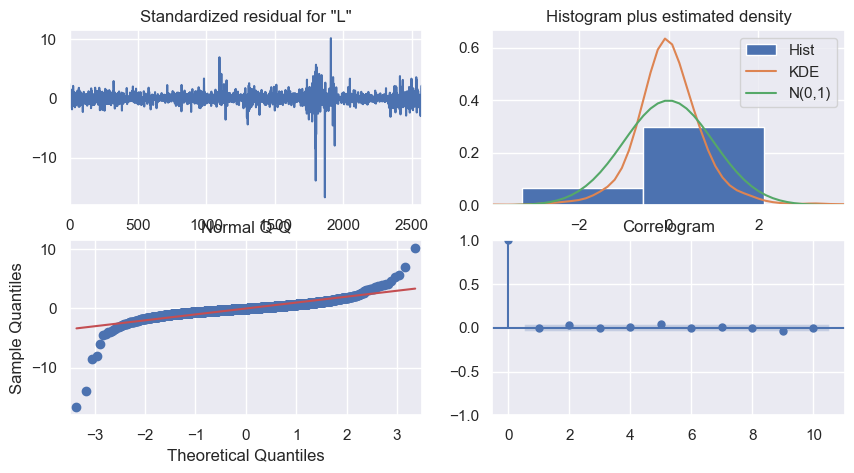

In [24]:
# Построение графиков диагностики остатков модели
_model_result.plot_diagnostics(figsize=(10, 5))  # отображает графики остатков: автокорреляции, нормальность, и т.д.
plt.show()  # отображение графиков

In [25]:
# Подгонка GARCH-модели на остатках ARMA-модели
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)  # указываем нулевое среднее, порядок GARCH(1,1)
_garch_result = _garch_model.fit(disp = 'off')  # подгоняем модель, отключаем вывод промежуточной информации
print(_garch_result.summary())  # выводим сводку результатов подгонки модели

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5141.24
Distribution:                  Normal   AIC:                           10288.5
Method:            Maximum Likelihood   BIC:                           10306.0
                                        No. Observations:                 2577
Date:                Mon, Apr 21 2025   Df Residuals:                     2577
Time:                        20:55:27   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0160  1.636e-02      0.979      0.328 

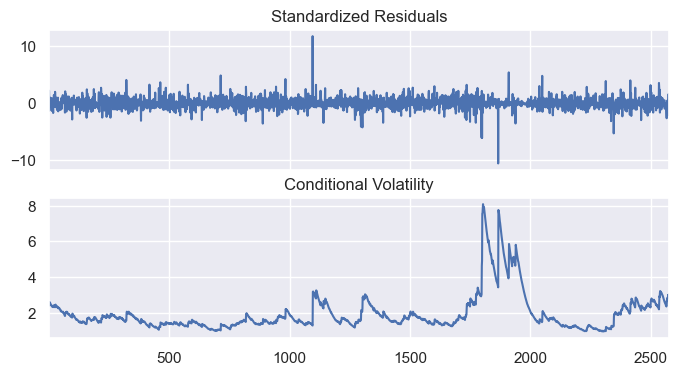

In [26]:
# Построение графиков подогнанной GARCH-модели
_garch_result.plot()  # отображаем графики подогнанной GARCH-модели, включая условную волатильность
plt.show()  # отображение графиков

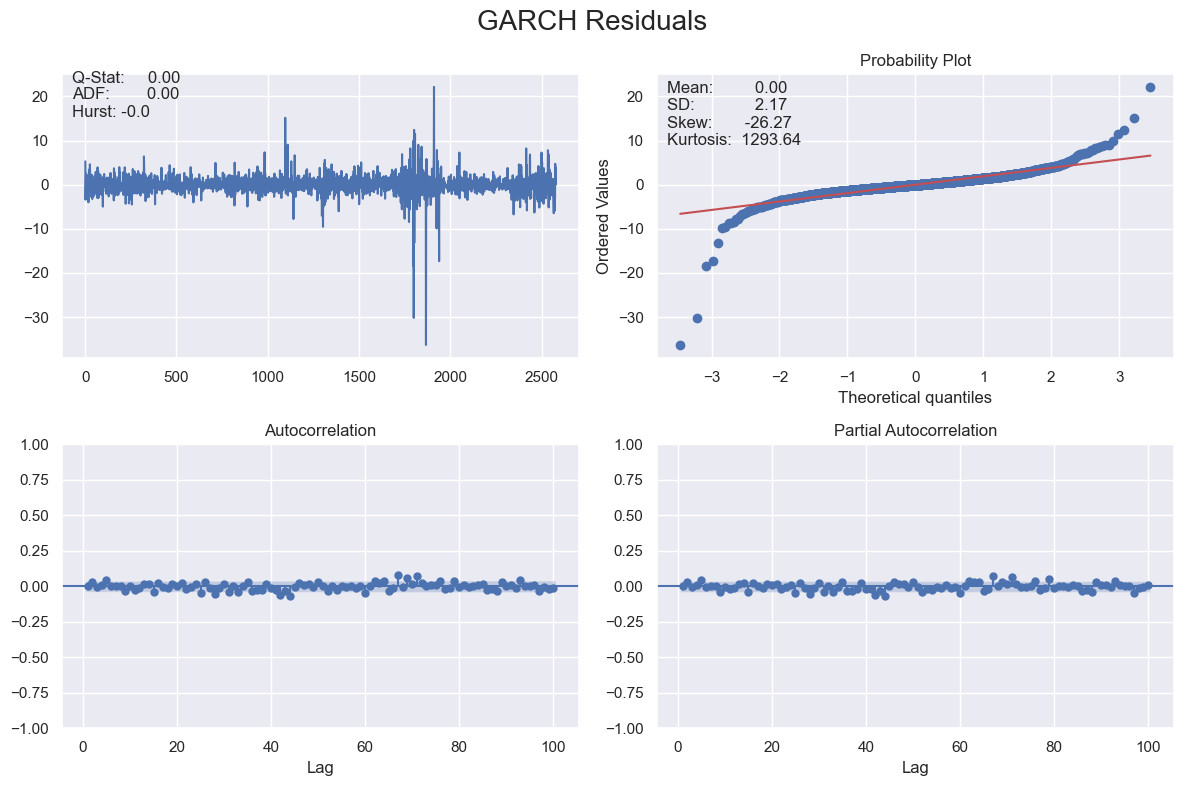

In [27]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='GARCH Residuals')

### Моделирование асимметричных реакций на волатильность

#### Эффект левереджа

- Коэффициент долга к капиталу = Долг / Капитал
- Когда цена акций падает, коэффициент долга к капиталу растет.
- Это означает больше рисков!

Модели GARCH предполагают, что положительные и отрицательные новости оказывают симметричное влияние на волатильность. Однако на практике рынок чаще всего идет вверх "по лестнице", а вниз "на лифте". То есть влияние новостей обычно асимметрично, и отрицательные новости имеют более сильное влияние на волатильность, чем положительные.

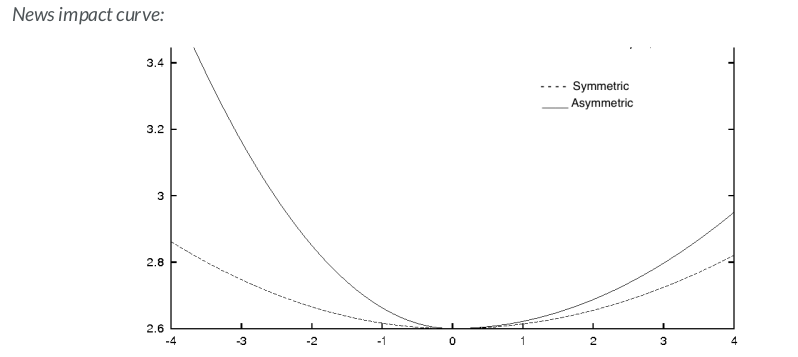

#### Модели GARCH, учитывающие асимметричные шоки:}

##### GJR-GARCH  
- Популярный вариант для моделирования асимметричных шоков.  
- GJR-GARCH в Python: arch_model(my_data, p = 1, q = 1, o = 1, mean = 'constant', vol = 'GARCH')

**Модель GJR-GARCH:**
$$
\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) + \beta \sigma_{t-1}^2
$$
где:
$$
I_{t-1} = \begin{cases}
0, & \text{если } r_{t-1} \geq \mu \\
1, & \text{если } r_{t-1} < \mu
\end{cases}
$$

##### EGARCH

- Экспоненциальный GARCH (EGARCH).
- Добавляется условная компонента для моделирования асимметрии в шоках, аналогично GJR-GARCH.  
- В отличие от GJR-GARCH, здесь нет ограничений на параметры $\alpha$ и $\beta$, что делает модель более быстрой.

**Модель EGARCH:**
$$
\log \sigma_t^2 = \omega + \sum_{k=1}^{q} \beta_k g(Z_{t-k}) + \sum_{k=1}^{p} \alpha_k \log \sigma_{t-k}^2
$$
где:$g(Z_t) = \theta Z_t + \lambda \left( |Z_t| - \mathbb{E}(|Z_t|) \right)$, $\sigma_t^2$ — условная дисперсия, а $\omega, \beta, \alpha, \theta, \lambda$ — коэффициенты модели.


### Подгонка моделей GARCH для криптовалюты

Финансовые рынки часто реагируют на позитивные и негативные новостные шоки по-разному, и одним из примеров таких колебаний является резкое изменение цен, наблюдаемое на рынке криптовалют в последние годы.

Мы реализуем модели GJR-GARCH и EGARCH в Python, которые являются популярными выбором для моделирования асимметричных реакций на волатильность.

Загрузим ежедневные данные о цене Bitcoin с API Blockchain.com:

In [28]:
bitcoin_data = sp_data

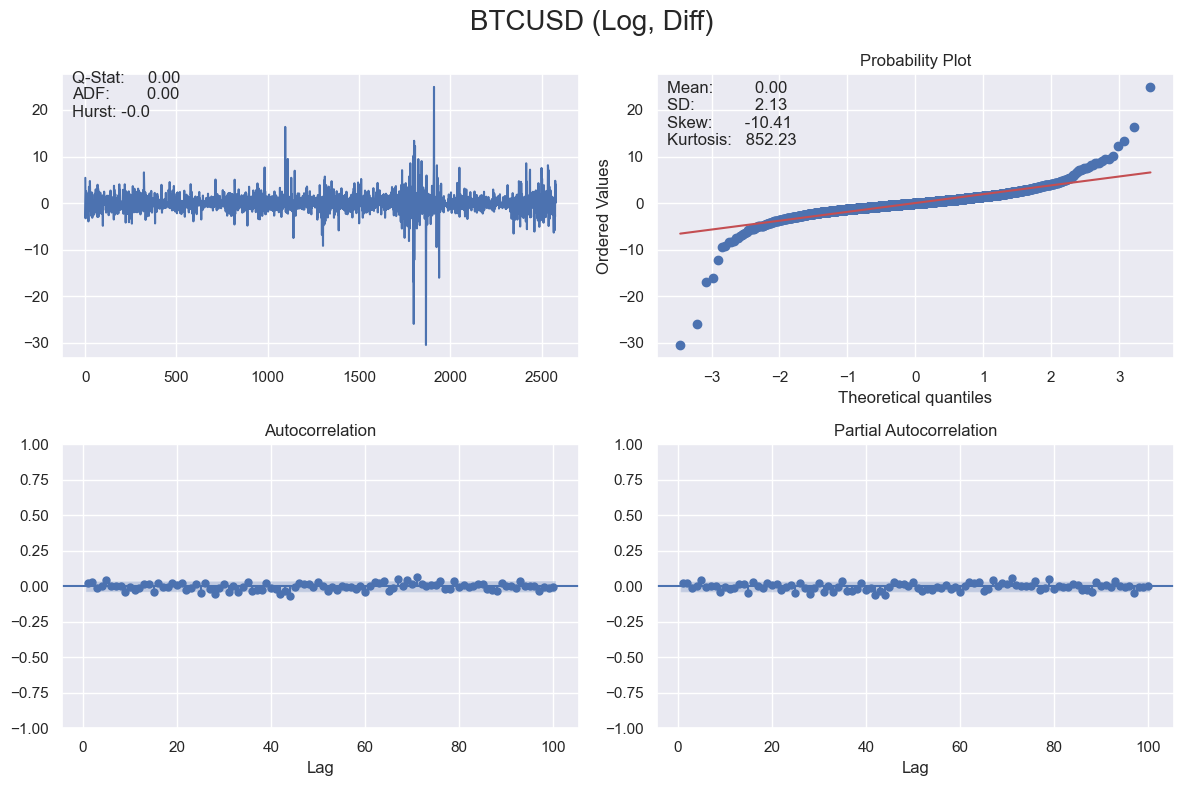

In [29]:
plot_correlogram(bitcoin_data['Return'], lags=100, title='BTCUSD (Log, Diff)')

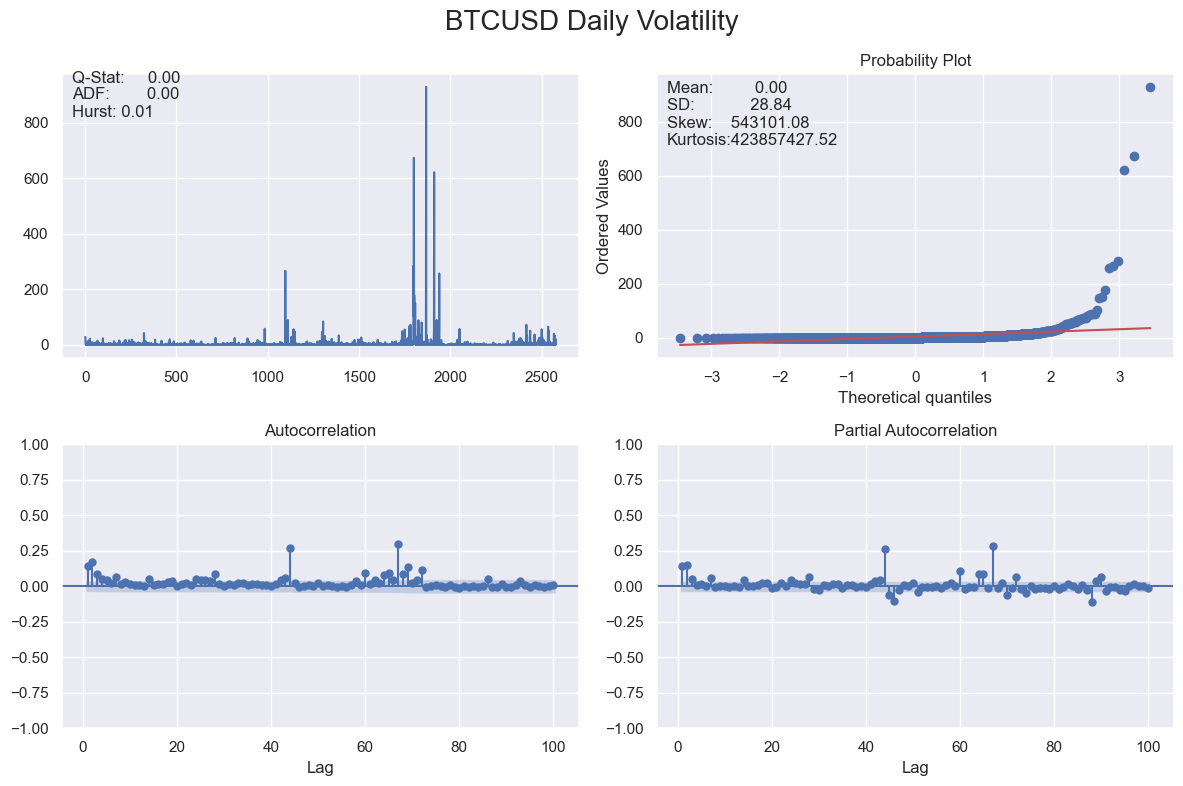

In [30]:
plot_correlogram(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), lags=100, title='BTCUSD Daily Volatility')

In [31]:
# Указать предположения модели GJR-GARCH
gjr_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Подогнать модель
gjrgm_result = gjr_gm.fit(disp = 'off')

# Вывести сводку подгонки модели
print(gjrgm_result.summary())


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -4837.02
Distribution:      Standardized Student's t   AIC:                           9686.05
Method:                  Maximum Likelihood   BIC:                           9721.18
                                              No. Observations:                 2577
Date:                      Mon, Apr 21 2025   Df Residuals:                     2576
Time:                              20:55:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [32]:
# Указать предположения модели EGARCH
egarch_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Подогнать модель
egarch_result = egarch_gm.fit(disp = 'off')

# Вывести сводку подгонки модели
print(egarch_result.summary())


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4826.20
Distribution:      Standardized Student's t   AIC:                           9664.39
Method:                  Maximum Likelihood   BIC:                           9699.52
                                              No. Observations:                 2577
Date:                      Mon, Apr 21 2025   Df Residuals:                     2576
Time:                              20:56:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

### Сравнение GJR-GARCH с EGARCH

Ранее мы подогнали модели GJR-GARCH и EGARCH для временного ряда доходности биткойна. Теперь мы сравним оцененную условную волатильность от двух моделей, построив их графики.

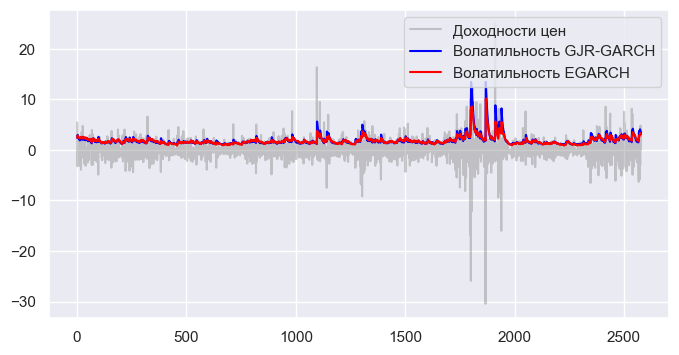

In [33]:
gjrgm_vol = gjrgm_result.conditional_volatility  # Получаем условную волатильность GJR-GARCH
egarch_vol = egarch_result.conditional_volatility  # Получаем условную волатильность EGARCH

# Строим график фактических доходностей биткойна
plt.plot(bitcoin_data['Return'], color = 'grey', alpha = 0.4, label = 'Доходности цен')

# Строим график оцененной волатильности GJR-GARCH
plt.plot(gjrgm_vol, color = 'blue', label = 'Волатильность GJR-GARCH')

# Строим график оцененной волатильности EGARCH
plt.plot(egarch_vol, color = 'red', label = 'Волатильность EGARCH')

plt.legend(loc = 'upper right')  # Отображаем легенду в правом верхнем углу
plt.show()  # Показываем график


In [34]:
# Выводим BIC для каждой модели
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')  # BIC для модели GJR-GARCH
print(f'\nEGARCH BIC: {egarch_result.bic}')  # BIC для модели EGARCH

GJR-GARCH BIC: 9721.175446852665

EGARCH BIC: 9699.516916518909


В целом, как модель GJR-GARCH, так и EGARCH хорошо справились с подгонкой данных. В сравнении GJR-GARCH более консервативен в оценке волатильности при применении к данным о Биткойне, но EGARCH дает более качественную модель.

#### Прогноз с использованием окна GARCH

- **Прогноз с расширяющимся окном:** постоянно добавлять новые данные в выборку.

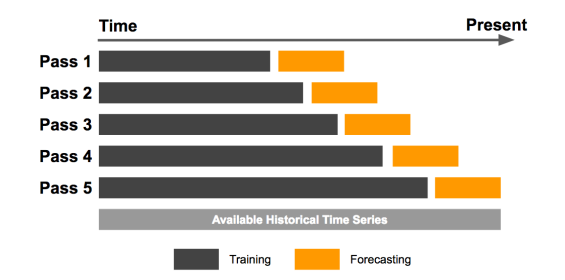

- **Прогноз с фиксированным скользящим окном:** новые данные добавляются, в то время как старые удаляются из выборки.

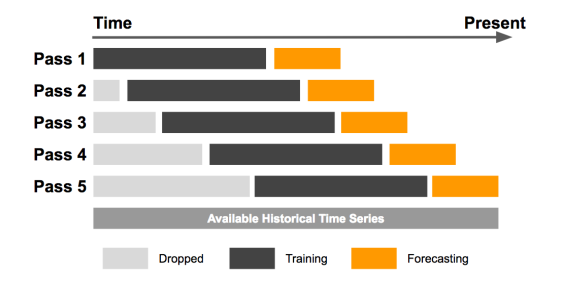

- Прогноз с скользящим окном

- Избегает смещения обратного взгляда (lookback bias).

- Менее подвержен переобучению (overfitting).

- Адаптирует прогноз к новым наблюдениям.


**Как определить размер окна?**

- Обычно определяется в каждом конкретном случае.

- Слишком большое окно: включает устаревшие данные, что может привести к высокому смещению (bias).

- Слишком узкое окно: исключает релевантные данные, что может привести к высокой дисперсии (variance).

- Оптимальный размер окна: компромисс для балансировки смещения и дисперсии.

### Прогноз с фиксированным скользящим окном

Прогнозы с использованием скользящего окна очень популярны в моделировании финансовых временных рядов. Мы научимся, как реализовать прогнозы модели GARCH с фиксированным скользящим окном.

Сначала определите размер окна в методе .fit() и выполните прогноз с помощью цикла for. Поскольку размер окна остается фиксированным, как начало, так и конец окна увеличиваются после каждой итерации.

In [93]:
index = sp_data['Date']
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    
    temp = res.forecast(horizon=1).variance
    #fcast = temp.iloc[i + end_loc - 1]
    fcast = temp.iloc[-1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


#### Реализовать прогнозирование с расширяющимся окном

In [94]:
index = sp_data['Date']
start_loc = 0
end_loc = np.where(index >= '2020-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[-1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

---------------------------------------------------------------------- Done!


#### Сравнение результатов прогнозирования

Разные подходы с применением скользящего окна могут приводить к различным результатам прогнозирования. Здесь мы подробнее рассмотрим эти результаты, сравнив их.

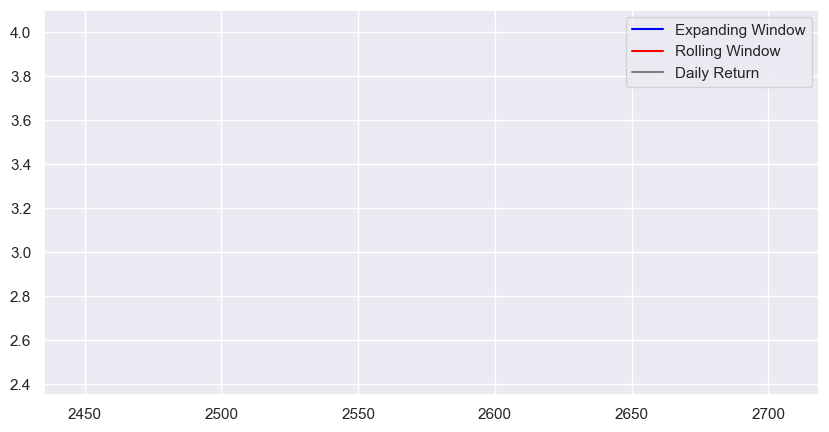

In [95]:
# Рассчитываем волатильность на основе прогноза дисперсии с расширяющимся окном
vol_expandwin = np.sqrt(variance_expandwin)

# Рассчитываем волатильность на основе прогноза дисперсии с фиксированным скользящим окном
vol_fixedwin = np.sqrt(variance_fixedwin)

# Строим график
plt.figure(figsize=(10,5))

# Строим прогноз волатильности с расширяющимся окном
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')

# Строим прогноз волатильности с фиксированным скользящим окном
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

# Строим график ежедневных доходностей
plt.plot(sp_data.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()


#### Упрощение модели с использованием p-значений

Леонардо да Винчи однажды сказал: "Простота — это высшая форма изысканности." Это также применимо к моделированию в области анализа данных. Мы будем практиковать использование p-значений, чтобы решить, какие параметры модели необходимы, и определим экономичную модель без незначимых параметров.

Нулевая гипотеза заключается в том, что значение параметра равно нулю. Если p-значение больше заданного уровня значимости, нулевая гипотеза не может быть отвергнута, что означает, что параметр статистически незначим и, следовательно, не является необходимым.

In [96]:
# Получаем статистику параметров из сводки модели
para_summary = pd.DataFrame({'parameter': gm_result.params,
                             'p-value': gm_result.pvalues})

# Выводим статистику параметров
print(para_summary)


          parameter   p-value
mu         0.040558  0.171550
omega      0.020804  0.274561
alpha[1]   0.037699  0.000867
beta[1]    0.959254  0.000000


### Упрощение модели с использованием t-статистики

Помимо p-значений, t-статистики также могут помочь в принятии решения о необходимости параметров модели. Мы будем использовать t-статистики для оценки значимости параметров модели.

**Что такое t-статистика?**

T-статистика вычисляется как разница между оценённым значением параметра и его ожидаемым средним (в данном случае нулём), делённая на стандартную ошибку. Абсолютное значение t-статистики является мерой расстояния, которое показывает, на сколько стандартных ошибок оценённый параметр отклоняется от 0. В качестве правила большого пальца, если t-статистика больше 2, то можно отвергнуть нулевую гипотезу.

In [97]:
# Получаем статистику параметров из сводки модели
para_summary = pd.DataFrame({'parameter': gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Проверяем t-статистику с помощью ручного расчёта
calculated_t = para_summary['parameter'] / para_summary['std-err']

# Выводим статистику параметров
print(para_summary)

          parameter   std-err    t-value
mu         0.040558  0.029664   1.367240
omega      0.020804  0.019040   1.092620
alpha[1]   0.037699  0.011319   3.330574
beta[1]    0.959254  0.014714  65.191487


### Тест Люнджа-Бокса

Тест Люнджа-Бокса проверяет, есть ли среди группы автокорреляций временного ряда такие, которые отличаются от нуля.

- H0: данные распределены независимо.
- P-значение < 5%: модель не является обоснованной.

Мы будем практиковать обнаружение автокорреляции в стандартизированных остатках, выполняя тест Люнджа-Бокса.

Нулевая гипотеза теста Люнджа-Бокса: данные распределены независимо. Если p-значение больше указанного уровня значимости, нулевая гипотеза не может быть отвергнута. Другими словами, нет явных признаков автокорреляций, и модель является валидной.

In [98]:
# Импортируем модуль Python
from statsmodels.stats.diagnostic import acorr_ljungbox

# Выполняем тест Люнджа-Бокса
lb_test = acorr_ljungbox(gm_std_resid, lags = 10)

# Сохраняем p-значения в DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Создаём имена столбцов для каждого лага
col_num = df.shape[1]
col_names = ['lag_' + str(num) for num in list(range(1, col_num + 1, 1))]

# Отображаем p-значения
df.columns = col_names
df

KeyError: 1

In [42]:
# Отображаем значимые лага
mask = df < 0.05
df[mask].dropna(axis=1)

NameError: name 'df' is not defined

### Качество подгонки модели
#### Может ли модель хорошо объяснить данные?

1. Максимальное правдоподобие
2. Информационные критерии (AIC, BIC)

- Максимальное правдоподобие: максимизировать вероятность получения наблюдаемых данных при предполагаемой модели. Предпочтительные модели имеют более высокие значения правдоподобия.

- Оценка максимального правдоподобия (MLE):
В статистике оценка максимального правдоподобия (MLE) — это метод оценки параметров вероятностного распределения путём максимизации функции правдоподобия, чтобы при предполагаемой статистической модели наблюдаемые данные были наиболее вероятными. Точка в пространстве параметров, которая максимизирует функцию правдоподобия, называется оценкой максимального правдоподобия.

- Функция правдоподобия:
В статистике функция правдоподобия (часто просто называемая правдоподобием) измеряет качество подгонки статистической модели под выборку данных для заданных значений неизвестных параметров. Она формируется из совместного распределения вероятностей выборки, но рассматривается и используется как функция только параметров, рассматривая случайные переменные как фиксированные на наблюдаемых значениях. Функция правдоподобия описывает гиперповерхность, вершина которой, если она существует, представляет собой комбинацию значений параметров модели, которые максимизируют вероятность получения выбранной выборки.

### Выбор победителя на основе логарифма правдоподобия

Мы будем практиковать использование логарифма правдоподобия для выбора модели с наилучшей подгонкой.

In [43]:
# Выводим логарифм правдоподобия для нормальной GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)

# Выводим логарифм правдоподобия для GARCH с асимметричным t-распределением
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

Log-likelihood of normal GARCH : -5138.460172744319
Log-likelihood of skewt GARCH : -4833.588583627565


### Бэктестинг с использованием MAE и MSE

Мы будем практиковать оценку производительности модели с помощью бэктестинга. Точность прогноза на данных, не входящих в выборку, оценивается путём вычисления MSE (среднеквадратичной ошибки) и MAE (средней абсолютной ошибки).

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [45]:
def evaluate(observation, forecast): 
    # Вызываем функцию sklearn для расчёта MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Средняя абсолютная ошибка (MAE): {round(mae, 3)}')
    
    # Вызываем функцию sklearn для расчёта MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Среднеквадратичная ошибка (MSE): {round(mse, 3)}')
    
    return mae, mse

# Бэктестинг модели с использованием MAE и MSE
evaluate(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), egarch_vol**2)

Средняя абсолютная ошибка (MAE): 5.241
Среднеквадратичная ошибка (MSE): 805.697


(5.240673072418588, 805.6966079657457)

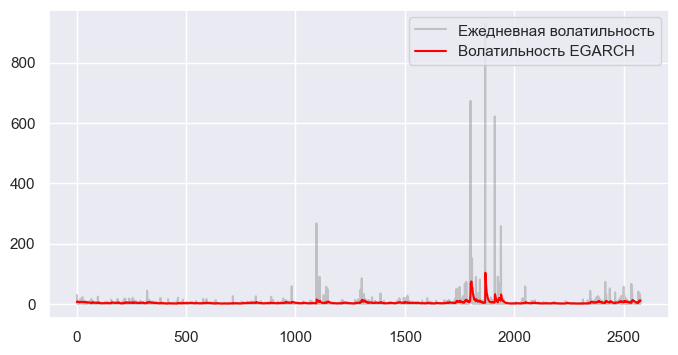

In [46]:
# Строим график реальной волатильности биткойна
plt.plot(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Ежедневная волатильность')

# Строим график оценённой волатильности EGARCH
plt.plot(egarch_vol**2, color = 'red', label = 'Волатильность EGARCH')

plt.legend(loc = 'upper right')
plt.show()

### Симуляция прогнозов

При использовании прогнозов, основанных на симуляции или бутстрэппинге, дополнительный атрибут объекта ARCHModelForecast имеет значение — симуляция.

#### Прогнозы на основе бутстрэппинга

Прогнозы, основанные на бутстрэппинге, почти идентичны прогнозам, основанным на симуляции, за исключением того, что значения, используемые для симуляции процесса, вычисляются на основе исторических данных, а не с использованием предполагаемого распределения остатков. Прогнозы, полученные этим методом, также возвращают объект ARCHModelForecastSimulation, содержащий информацию о сымулированных путях.

In [47]:
# Пути для последнего наблюдения
sim_forecasts = egarch_result.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

#### Сравнение путей

Пути доступны в атрибуте simulations. Построение путей показывает важные различия между двумя сценариями, помимо средних различий. Оба начинают с одной и той же точки.

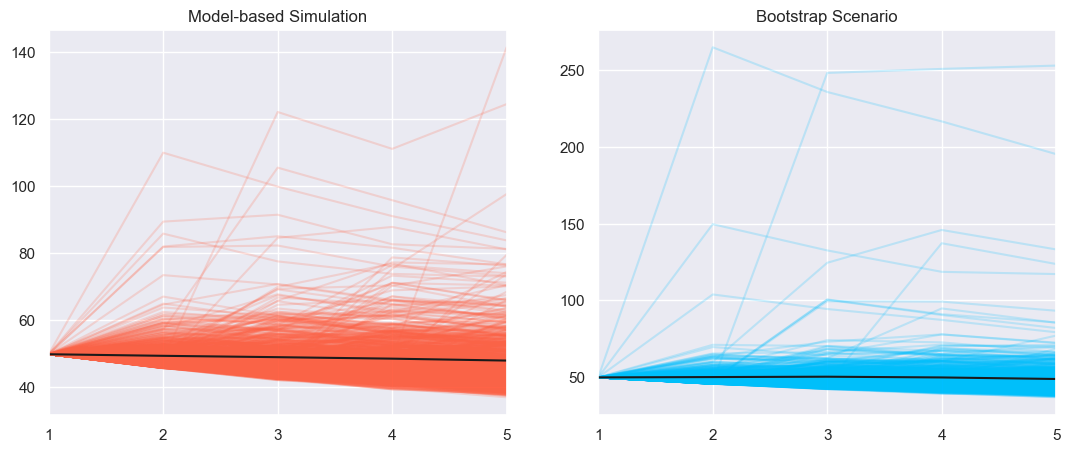

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

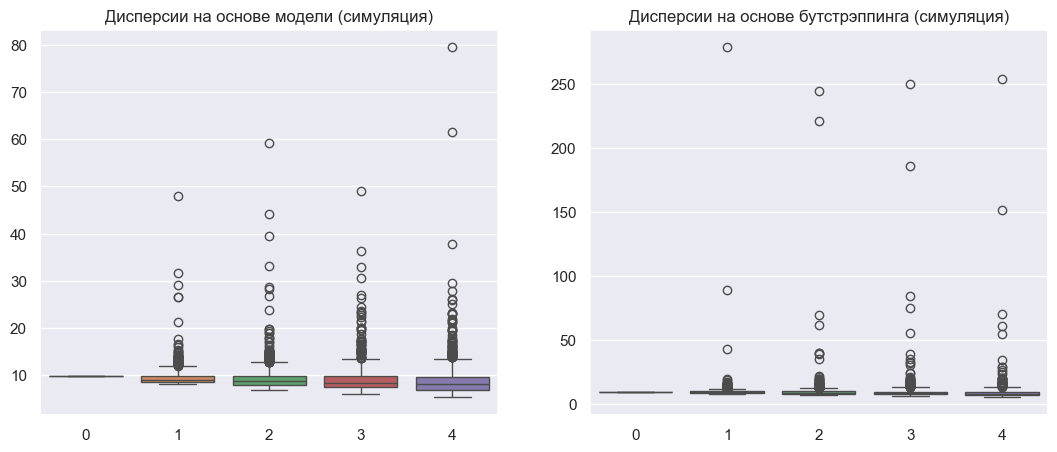

In [49]:
# Строим график дисперсий симуляции
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Дисперсии на основе модели (симуляция)')
axes[1].set_title('Дисперсии на основе бутстрэппинга (симуляция)')

plt.show()


### VaR в управлении финансовыми рисками

**Что такое VaR?** VaR означает Value at Risk (Стоимость на риск).

Три составляющие:
- Портфель
- Временной горизонт
- Вероятность

**Примеры VaR**

- 1-дневный 5% VaR для $1 миллиона

- 5% вероятность того, что стоимость портфеля снизится на 1 миллион долларов или больше за 1 день.

- 10-дневный 1% VaR для $9 миллионов

- 1% вероятность того, что стоимость портфеля снизится на 9 миллионов долларов или больше за 10 дней.


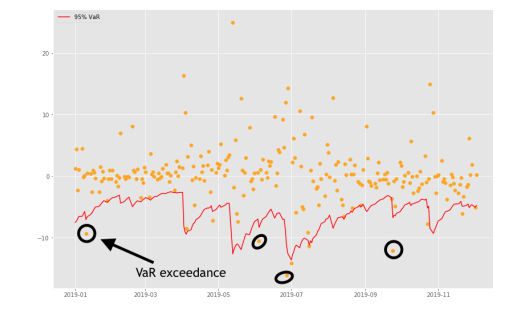

Предположим, что 5% ежедневный VaR и 252 торговых дня в году. Модель VaR с оценкой рисков должна иметь меньше 13 случаев превышения VaR в год, то есть 5% * 252. Если случаев превышения больше, значит, модель недооценит риск.

**Динамический VaR с GARCH**

- Более реалистичная оценка VaR с использованием GARCH
- VaR = среднее + (волатильность GARCH) * квантиль

**Параметрический VaR**
- Оценка квантилей на основе предполагаемого распределения стандартизированных остатков GARCH.

**Эмпирический VaR**
- Оценка квантилей на основе наблюдаемого распределения стандартизированных остатков GARCH.

#### Вычисление параметрического VaR

Мы будем практиковать оценку динамических ежедневных VaR на уровнях 5% и 1% с использованием параметрического подхода.

Напоминаем, что для выполнения прогнозирования VaR необходимо пройти три шага.

Шаг 1: Использовать модель GARCH для прогнозирования дисперсии.

Шаг 2: Получить прогнозируемое среднее и волатильность с помощью GARCH.

Шаг 3: Вычислить квантиль в соответствии с заданным уровнем доверия. Параметрический подход оценивает квантиль на основе предполагаемого распределения.

In [50]:
am = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
res = am.fit(disp='off', last_obs='2018-01-01')

AssertionError: 

In [51]:
forecasts = res.forecast(start='2019-01-01')
cond_mean = forecasts.mean['2019':]
cond_var = forecasts.variance['2019':]
q = am.distribution.ppf([0.01, 0.05], res.params[5])
print(q)

NameError: name 'res' is not defined

In [52]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

NameError: name 'cond_mean' is not defined

In [53]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return['2019':]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')

labels = {
    
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}

markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}

for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Parametric VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

NameError: name 'value_at_risk' is not defined

#### Вычисление эмпирического VaR

Мы будем практиковать оценку динамических ежедневных VaR на уровнях 5% и 1% с использованием эмпирического подхода.

Разница между параметрическим и эмпирическим VaR заключается в способе оценки квантилей.
Параметрический подход оценивает квантиль на основе предполагаемого распределения,
в то время как эмпирический подход оценивает квантиль на основе наблюдаемого распределения стандартизированных остатков.

In [54]:
# Получаем оценённые остатки модели и условную волатильность
gm_resid = res.resid
gm_std = res.conditional_volatility

# Вычисляем стандартизированные остатки
gm_std_resid = gm_resid / gm_std

# Получаем эмпирические квантильные значения
q = gm_std_resid.quantile([.01, .05])
print(q)

NameError: name 'res' is not defined

In [55]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['1%', '5%'], index=cond_var.index)
value_at_risk.describe()

NameError: name 'cond_mean' is not defined

In [56]:
ax = value_at_risk.plot(legend=False, figsize=(12,6))
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])

rets_2019 = bitcoin_data.Return['2019':]
rets_2019.name = 'BTCUSD Return'

c = []
for idx in value_at_risk.index:
    if rets_2019[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2019[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
        
c = np.array(c, dtype='object')
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2019.index[sel],
        -rets_2019.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color])
    
ax.set_title('Filtered Historical Simulation VaR')
ax.legend(frameon=False, ncol=3)

plt.show()

NameError: name 'value_at_risk' is not defined

#### Постройте график 5% дневного VaR вместе с ценой

NameError: name 'value_at_risk' is not defined

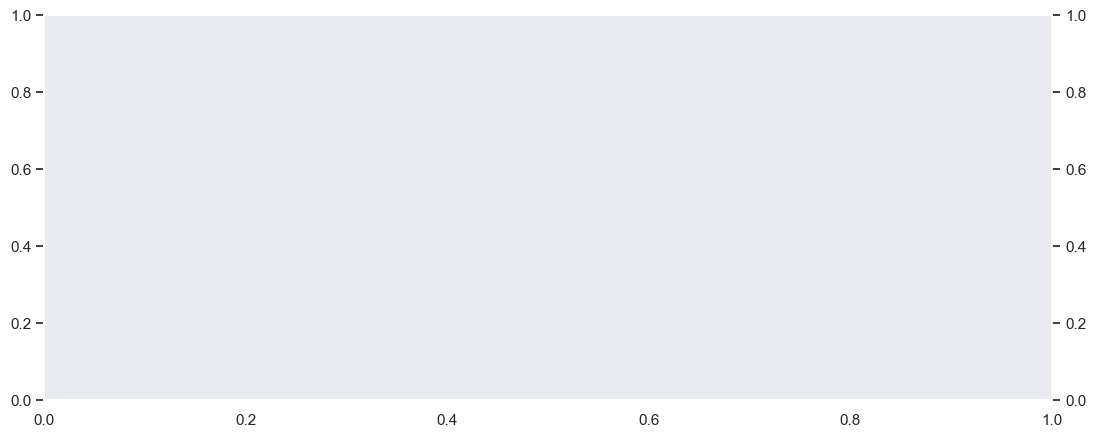

In [57]:
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.grid(False)
ax2.grid(False)

ax1.plot(bitcoin_data.loc[value_at_risk.index[0]:].index, bitcoin_data.loc[value_at_risk.index[0]:].Close, 
         color='red', label='BTCUSD')
ax2.plot(value_at_risk['5%'].index, value_at_risk['5%'], color='grey', label='VaR', alpha=0.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('BTCUSD Close')
ax2.set_ylabel('VaR')

ax1.legend(loc='upper left')
ax2.legend()

plt.show()

### Что такое ковариация?

- Ковариация описывает взаимосвязь между изменениями двух переменных

- Положительная ковариация: когда одна переменная увеличивается, другая, как правило, тоже увеличивается. Они двигаются вместе.

- Отрицательная ковариация: когда одна переменная увеличивается, другая, как правило, уменьшается. Они двигаются в противоположных направлениях.

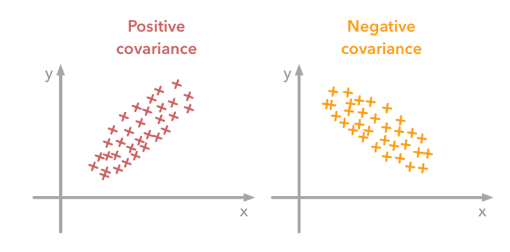


**Динамическая ковариация с GARCH**

Если доходности двух активов имеют корреляцию $\rho$ и изменяющуюся во времени волатильность $\sigma_{1}$ и $\sigma_{2}$, то ковариация между ними рассчитывается по формуле:

$$Covariance=\rho*\sigma_{1}*\sigma_{2}$$

### Вычисление ковариации с помощью GARCH

Мы попрактикуемся в расчёте динамической ковариации с использованием моделей GARCH.

In [58]:
start = pd.Timestamp('2012-01-01')
end = pd.Timestamp('2020-01-06')

sp_data = web.DataReader('SPY', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

sp_data.info()

AttributeError: 'NoneType' object has no attribute 'group'

In [59]:
tmf_data = web.DataReader('TMF', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

tmf_data.info()

AttributeError: 'NoneType' object has no attribute 'group'

In [60]:
upro_data = web.DataReader('UPRO', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

upro_data.info()

AttributeError: 'NoneType' object has no attribute 'group'

**Plot Price Data**

In [61]:
prices = pd.DataFrame({'UPRO': upro_data['Close'],
                       'SPY': sp_data['Close'],
                       'TMF': tmf_data['Close']})

prices.div(prices.iloc[0,:]).plot(figsize=(12, 6))# Normalize Prices 

NameError: name 'upro_data' is not defined

**Calculate Returns**

In [62]:
tmf_data['Return'] = np.log(tmf_data['Close']).diff().mul(100) # rescale to faciliate optimization
tmf_data = tmf_data.dropna()

upro_data['Return'] = np.log(upro_data['Close']).diff().mul(100) # rescale to faciliate optimization
upro_data = upro_data.dropna()

sp_data['Return'] = np.log(sp_data['Close']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

NameError: name 'tmf_data' is not defined

**Find best Model**

In [64]:
sp_model = pm.auto_arima(sp_data['Return'],

d=0,  # порядок дифференцирования (без сезонности)
start_p=1,  # начальное значение для p (AR-порядок)
start_q=1,  # начальное значение для q (MA-порядок)
max_p=4,  # максимальное значение p, которое будет протестировано
max_q=4,  # максимальное значение q, которое будет протестировано                        

seasonal=False,  # указывает, что ряд не сезонный

information_criterion='bic',  # критерий выбора наилучшей модели (BIC)
trace=True,  # выводить результаты в процессе подбора модели
error_action='ignore',  # игнорировать комбинации порядков, вызывающие ошибки
stepwise=True,  # использовать пошаговый алгоритм поиска наилучшей модели

)


Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=11231.306, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=11217.947, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=11224.776, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=11224.829, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=11225.538, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.450 seconds


In [65]:
print(sp_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2577
Model:                        SARIMAX   Log Likelihood               -5605.046
Date:                Mon, 21 Apr 2025   AIC                          11212.093
Time:                        20:40:37   BIC                          11217.947
Sample:                             0   HQIC                         11214.215
                               - 2577                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.5366      0.028    161.263      0.000       4.481       4.592
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):            158973.04
Prob(Q):                              0.31   Pr

In [66]:
tmf_model = pm.auto_arima(tmf_data['Return'],

d=0,  # порядок дифференцирования (без сезонности)
start_p=1,  # начальное значение для p (AR-порядок)
start_q=1,  # начальное значение для q (MA-порядок)
max_p=4,  # максимальное значение p, которое будет протестировано
max_q=4,  # максимальное значение q, которое будет протестировано                        

seasonal=False,  # указывает, что ряд не сезонный

information_criterion='bic',  # критерий выбора наилучшей модели (BIC)
trace=True,  # печатать результаты во время подбора модели
error_action='ignore',  # игнорировать ошибочные комбинации параметров
stepwise=True,  # использовать пошаговый интеллектуальный подбор модели

)


NameError: name 'tmf_data' is not defined

In [67]:
print(tmf_model.summary())

NameError: name 'tmf_model' is not defined

In [68]:
upro_model = pm.auto_arima(upro_data['Return'],

d=0,  # порядок дифференцирования (без сезонности)
start_p=1,  # начальное предположение для параметра p (авторегрессия)
start_q=1,  # начальное предположение для параметра q (скользящее среднее)
max_p=4,  # максимальное значение p для перебора
max_q=4,  # максимальное значение q для перебора                        

seasonal=False,  # указывает, что временной ряд не сезонный

information_criterion='bic',  # критерий информации BIC для выбора наилучшей модели
trace=True,  # выводить процесс подбора модели в консоль
error_action='ignore',  # игнорировать ошибки неподходящих параметров
stepwise=True,  # использовать пошаговый (интеллектуальный) подбор модели

)


NameError: name 'upro_data' is not defined

In [69]:
print(upro_model.summary())

NameError: name 'upro_model' is not defined

**Fit best Model**

In [70]:
_arma_sp = sm.tsa.SARIMAX(endog=sp_data['Return'],order=(0, 0, 0))
_sp_model_result = _arma_sp.fit()

egarch_sp = arch_model(_sp_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
sp_gm_result = egarch_sp.fit(disp = 'off')
print(sp_gm_result.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4826.79
Distribution:      Standardized Student's t   AIC:                           9663.58
Method:                  Maximum Likelihood   BIC:                           9692.86
                                              No. Observations:                 2577
Date:                      Mon, Apr 21 2025   Df Residuals:                     2577
Time:                              20:42:11   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

In [71]:
_arma_tmf = sm.tsa.SARIMAX(endog=tmf_data['Return'],order=(0, 0, 0))
_tmf_model_result = _arma_tmf.fit()

egarch_tmf = arch_model(_tmf_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
tmf_gm_result = egarch_tmf.fit(disp = 'off')
print(tmf_gm_result.summary())

NameError: name 'tmf_data' is not defined

In [72]:
_arma_upro = sm.tsa.SARIMAX(endog=upro_data['Return'],order=(0, 0, 0))
_upro_model_result = _arma_upro.fit()

egarch_upro = arch_model(_upro_model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't', mean = 'zero')
upro_gm_result = egarch_upro.fit(disp = 'off')
print(upro_gm_result.summary())

NameError: name 'upro_data' is not defined

In [73]:
# Шаг 1: Подогнать GARCH-модели и получить волатильность для каждого ряда доходностей
vol_tmf = tmf_gm_result.conditional_volatility  # волатильность TMF
vol_upro = upro_gm_result.conditional_volatility  # волатильность UPRO

NameError: name 'tmf_gm_result' is not defined

In [74]:
# Шаг 2: Вычислить стандартизированные остатки из подогнанных GARCH-моделей
resid_tmf = tmf_gm_result.resid / vol_tmf  # стандартизированные остатки для TMF
resid_upro = upro_gm_result.resid / vol_upro  # стандартизированные остатки для UPRO

NameError: name 'tmf_gm_result' is not defined

In [75]:
# Шаг 3: Вычислить ρ как простую корреляцию стандартизированных остатков
corr = np.corrcoef(resid_tmf, resid_upro)[0,1]  # корреляция между остатками TMF и UPRO

NameError: name 'resid_tmf' is not defined

In [76]:
# Шаг 4: Вычислить ковариацию GARCH, умножив корреляцию и волатильность.
covariance = corr * vol_tmf * vol_upro  # ковариация GARCH между TMF и UPRO

NameError: name 'corr' is not defined

In [77]:
# Построить график данных
plt.plot(covariance, color='red')  # график ковариации GARCH
plt.title('GARCH Ковариация')  # заголовок графика
plt.show()  # показать график

NameError: name 'covariance' is not defined

### Вычисление динамической дисперсии портфеля

Мы будем практиковаться в вычислении дисперсии простого двухактивного портфеля с использованием динамической ковариации GARCH.

Теория современного портфеля (MPT):
МPT утверждает, что существует оптимальный способ построить портфель, чтобы использовать эффект диверсификации. Это позволяет достичь желаемого уровня ожидаемой доходности при минимальном риске. Эффект диверсификации особенно очевиден, когда ковариация между доходностями активов отрицательная, что позволяет снизить общий риск портфеля.

**Найти оптимальные веса для максимального коэффициента Шарпа**

In [78]:
data = {}
for perc in range(100):
    daily = (1 - perc / 100) * tmf_data["Return"] + (perc / 100) * upro_data["Return"]
    data[perc] = daily.mean() / daily.std() * (252 ** 0.5)
    
sx = pd.Series(data)
s = pd.DataFrame(sx, index=sx.index)
ax = s.plot(title="UPRO/TMF allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio UPRO")
plt.show()

tmf_w = 100 - s.idxmax()[0]
print('Optimal UPRO Weight =', s.idxmax()[0])
print('Optimal TNF Weight =', tmf_w)
print('Optimal Sharpe Ratio =', s.max()[0])

NameError: name 'tmf_data' is not defined

In [79]:
# Определение весов
Wa1 = 0.64
Wa2 = 0.36

Wb1 = 0.49
Wb2 = 1 - Wb1

# Расчёт дисперсии доходностей каждого актива
variance_upro = np.var(upro_data['Return'])
variance_tmf = np.var(tmf_data['Return'])

# Расчёт дисперсии портфеля
portvar_a = Wa1**2 * variance_tmf + Wa2**2 * variance_upro + 2*Wa1*Wa2*covariance
portvar_b = Wb1**2 * variance_tmf + Wb2**2 * variance_upro + 2*Wb1*Wb2*covariance

# Построение графиков
plt.plot(portvar_a, color='red', label='Портфель a')
plt.plot(portvar_b, color='deepskyblue', label='Портфель b')
plt.title('Ковариация')
plt.legend(loc='best')
plt.show()


NameError: name 'upro_data' is not defined

### Что такое Бета?

**Бета акций** — это мера волатильности акции относительно общего рынка.

**Систематический риск:** Часть риска, которую нельзя диверсифицировать.

**Бета в управлении портфелем**

- Оценка инвестиционного риска
- Бета рынка = 1: используется как эталон.
- Бета > 1: акция несет больше рисков, чем общий рынок.
- Бета < 1: акция несет меньше рисков, чем общий рынок.

**Динамическая Бета с использованием GARCH**
$$Beta=\rho*\frac{\sigma_{stock}}{\sigma_{market}}$$

In [80]:
# 1). Вычисление корреляции между S&P500 и акцией
resid_stock = tmf_gm_result.resid / tmf_gm_result.conditional_volatility
resid_sp500 = sp_gm_result.resid / sp_gm_result.conditional_volatility

correlation = np.corrcoef(resid_stock, resid_sp500)[0, 1]

# 2). Вычисление динамической беты для акции
stock_beta = correlation * (tmf_gm_result.conditional_volatility / sp_gm_result.conditional_volatility)

NameError: name 'tmf_gm_result' is not defined

NameError: name 'stock_beta' is not defined

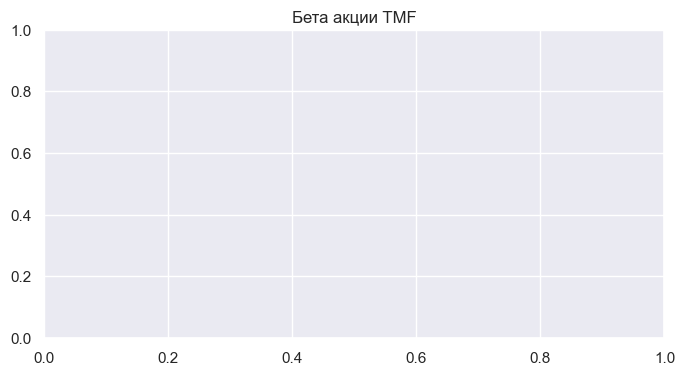

In [81]:
# Построение графика Беты
plt.title('Бета акции TMF')
plt.plot(stock_beta)
plt.show()